# Assignment 3: Data Cleaning, Aggregation, and Visulization

OPIM 5894 Data Science with Python 

Instructor: Jing Peng

Name:   NetID:

Discussed with: if any

## Instructions
-  Always print out the results of each step. <br>
-  Before you start working on the assignment, it is helpful to get familiar with keyboard shortcuts (under Help menu). <br>
-  Don't get panic if you find something not demonstrated in class. Your best friend Google is there for you.
-  When you are done, go to the Notebook Menu Cell -> Run All, to run the code from beginning to end. <br>
-  Save the notebook file as both lastname.ipynb and lastname.html. Submit them and wide.csv to HuskyCT.<br>

You are supposed to finish this assignment on your own. If you have to discuss with others, please mention who you have discussed with on each question. Honesty is highly appreciated, so there is no penalty for disclosing such information.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
# use the code below to make sure plot is shown in Notebook
%matplotlib inline 

## 1. Data Cleaning

### 1.1 Load Data (loans.xlsx) into Memory
The dataset is a random sample of the Kaggle dataset: https://www.kaggle.com/wendykan/lending-club-loan-data/data.
Some limited documentation are available on the webpage if you click "loan.csv" on the left, then click "Column MetaData". The meanings of some columns can be found by Google. For example "dti" means debit to income ratio.

In [4]:
import os
os.chdir('D:/Dropbox/Teaching/Data Science using Python/Notebooks')
# Subset generatation
# loans = pd.read_csv('loan.csv', low_memory=False)
# subset = loans.sample(n=20000)
# subset.to_excel('loan_20K.xlsx', index=False)
loans = pd.read_excel('loans.xlsx', na_values=['NaN',''])

### 1.2 Remove Prolematic Columns
Write some code to identify the "bad" columns (can't just look at a column mannually and then decide to drop it) and **explain which columns are removed in each step.**

1.2.1 Drop all columns for which more than 10% of values are missing
Using such attributes may lead to bias, unless appropriate imputation is applied on the missing values

In [5]:
missing_rate = loans.isnull().mean()
loans.columns[missing_rate>0.1]

Index(['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint'],
      dtype='object')

In [6]:
loans = loans.loc[:, missing_rate<=0.1]

1.2.2 Drop all columns with only one value (missing value does not count)
Such attributes have no variation and are not informative at all

In [7]:
loans.columns[loans.nunique()==1]

Index(['pymnt_plan', 'policy_code'], dtype='object')

In [8]:
loans = loans.loc[:, loans.nunique()>=2]

1.2.3 Drop all columns for which more than 98% of observations has the same value (missing value does not count)
Such attributes may lead to singularity issue if used, as they are close to a constant. The cutoff 98% is a bit arbitrary.

In [9]:
flag = []
for col in loans.columns:
    top_freq = loans[col].value_counts().iloc[0]
    flag.append(top_freq > len(loans.index) * 0.97)

In [10]:
loans.columns[flag]

Index(['collections_12_mths_ex_med', 'application_type', 'acc_now_delinq'], dtype='object')

In [11]:
loans.drop(labels=loans.columns[flag], axis=1, inplace=True)

In [12]:
# Now print the column index of the data
loans.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec'],
      dtype='object')

In [13]:
# Print the number of columns
len(loans.columns)

19

### 1.3 Data Transformation

1.3.1 Convert the "term" column to numeric and "issue_d" to datetime. Please Google how to convert string to numeric. If you don't know how to do this, you can finish the rest of the assignment by using the string version of term

In [14]:
loans.issue_d = pd.to_datetime(loans.issue_d)
loans['term'] = pd.to_numeric(loans['term'].str.extract('(\d+)', expand=False))

1.3.2 In the "home_ownership" columns, set values with "ANY", "OTHER", and "NONE" as missing

In [15]:
loans.home_ownership.value_counts(dropna=False)

MORTGAGE    9903
RENT        8083
OWN         2006
OTHER          5
NONE           2
ANY            1
Name: home_ownership, dtype: int64

In [16]:
loans.home_ownership.replace(to_replace=dict(ANY=None, OTHER=None, NONE=None), inplace=True)

In [17]:
loans.home_ownership.value_counts(dropna=False)

MORTGAGE    9903
RENT        8083
OWN         2006
NaN            8
Name: home_ownership, dtype: int64

1.3.3 The interest rate for the last 100 observations are missing. Replacing them with the average interest rate of the loans in the same state and with the same term.  

In [18]:
loans['int_rate'] = loans.groupby(['addr_state','term'])['int_rate'].transform(lambda x: x.fillna(x.mean()))

In [19]:
loans

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec
0,6000,6000,36,6.990000,185.24,A,A3,OWN,50000.00,Not Verified,2015-01-01,Current,AL,25.06,0,Nov-1998,0,7,0
1,15000,15000,36,15.410000,523.00,D,D1,RENT,58000.00,Verified,2015-11-01,Current,NV,22.99,0,Sep-1998,0,16,0
2,6000,6000,36,12.990000,202.14,C,C1,RENT,52700.00,Not Verified,2014-09-01,In Grace Period,CA,21.16,0,Aug-1990,0,20,0
3,20000,20000,36,14.650000,689.89,C,C5,RENT,77500.00,Verified,2015-02-01,Current,VA,29.67,0,Dec-1992,1,25,2
4,35000,35000,36,13.980000,1195.88,C,C3,MORTGAGE,87000.00,Source Verified,2014-07-01,Current,CA,22.33,1,May-1988,0,9,0
5,20000,20000,36,13.530000,679.00,B,B5,RENT,85000.00,Source Verified,2014-01-01,Charged Off,WA,11.87,0,Nov-1996,0,9,0
6,27175,27175,60,17.570000,683.73,D,D4,MORTGAGE,170000.00,Source Verified,2015-06-01,Current,CA,15.97,0,Mar-2005,1,16,0
7,18825,18825,36,15.610000,658.22,D,D1,RENT,42000.00,Not Verified,2014-08-01,Fully Paid,DC,14.43,6,Dec-1992,0,11,0
8,5000,5000,36,8.180000,157.10,B,B1,MORTGAGE,66000.00,Source Verified,2015-09-01,Current,NH,8.65,0,Dec-2004,1,6,0
9,10000,10000,36,12.490000,334.49,B,B5,RENT,60000.00,Not Verified,2014-07-01,Charged Off,NY,5.82,3,Apr-2007,0,5,0


In [20]:
# Verify the results if you have doubts
zz = loans.groupby(['addr_state','term'])['int_rate'].mean()

In [21]:
zz['PA'][36]

12.299279661016918

In [22]:
zz['LA'][60]

16.091025641025642

## 2. Data Exploration
Hints: the questions below often involve data aggregation and/or reshaping

### 2.1 Aggregate Statistics
2.1.1 Calculate the mean, std, and max of loan_amnt, int_rate, and installment, grouped by home_ownership

In [23]:
zz = loans.groupby('home_ownership')['loan_amnt','int_rate','installment'].agg([np.mean, np.std, np.max])
zz

loan_amnt                       int_rate                   \
                        mean          std   amax       mean       std   amax   
home_ownership                                                                 
MORTGAGE        16367.176613  8732.878021  35000  12.994141  4.392727  28.99   
OWN             14128.539382  8282.996505  35000  13.153123  4.547944  28.49   
RENT            12763.002598  7467.144262  35000  13.555785  4.251060  27.88   

               installment                       
                      mean         std     amax  
home_ownership                                   
MORTGAGE        475.136414  251.613042  1362.70  
OWN             422.859776  241.276562  1330.70  
RENT            388.181368  220.047197  1327.45

2.1.2 Now reshape the above results, such that home_ownership and variable names (loan_amnt, int_rate, and installment) are indexes on the column, whereas the statistics (mean, std, max) are indexes on the row

In [24]:
zz.stack(1).unstack(0)

loan_amnt                               int_rate  \
home_ownership      MORTGAGE           OWN          RENT   MORTGAGE   
mean            16367.176613  14128.539382  12763.002598  12.994141   
std              8732.878021   8282.996505   7467.144262   4.392727   
amax            35000.000000  35000.000000  35000.000000  28.990000   

                                      installment                            
home_ownership        OWN       RENT     MORTGAGE          OWN         RENT  
mean            13.153123  13.555785   475.136414   422.859776   388.181368  
std              4.547944   4.251060   251.613042   241.276562   220.047197  
amax            28.490000  27.880000  1362.700000  1330.700000  1327.450000

### 2.2 Visualization

2.2.1 Plot the means and errors (use one standard deviation of population) of "loan_amnt" and "int_rate" by different types of "grade", in two subplots

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000287D2A74C88>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000287D6A10198>], dtype=object)

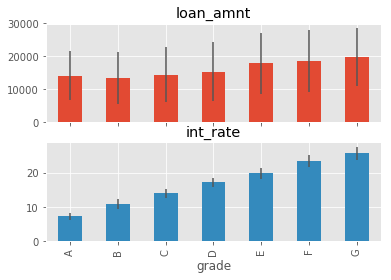

In [25]:
grouped = loans.groupby('grade')['loan_amnt', 'int_rate']
means = grouped.mean()
errors = grouped.std()
means.plot.bar(yerr=errors, subplots=True, legend=False)

2.2.2 Plot the histograms of "loan_amnt" under different types of "term" in one plot

term
36    Axes(0.125,0.125;0.775x0.755)
60    Axes(0.125,0.125;0.775x0.755)
Name: loan_amnt, dtype: object

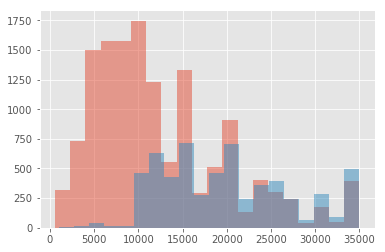

In [26]:
loans.groupby('term')['loan_amnt'].hist(alpha=0.5, bins=20)

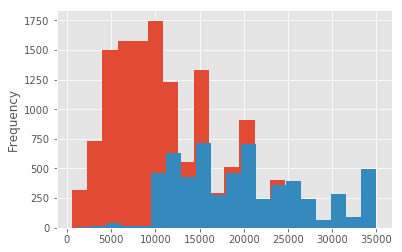

In [27]:
ax = loans.loan_amnt[loans.term==36].plot.hist(bins=20)
loans.loan_amnt[loans.term==60].plot.hist(ax=ax, bins=20)

2.2.3 Make a plot that shows the number of loans in each month (based on column "issue_d"). Meanwhile, plot the total amount of loans in each month on the secondary y axis. Properly annotate the graph (e.g., title, legend, x and y labels), such that it is easy to read. Set the figure size to be 10 (Height) by 12 (Width)

In [28]:
loan_stats = loans.groupby('issue_d')['loan_amnt'].agg([len, np.sum]).rename(columns={'len':'N','sum':'total'})
# loan_stats

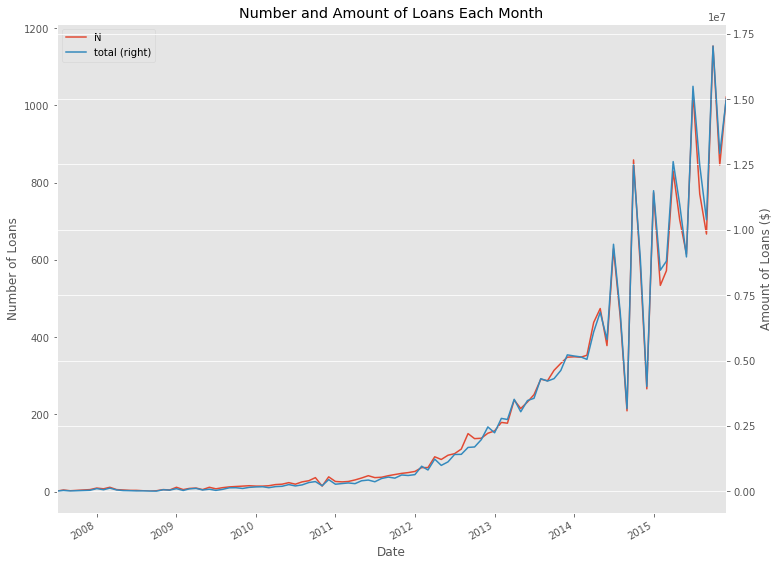

In [29]:
ax = loan_stats.N.plot(figsize=(12,10), legend=True)
loan_stats.total.plot(ax=ax, secondary_y=True, legend=True)
ax.set_title('Number and Amount of Loans Each Month')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Loans')
ax.right_ax.set_ylabel('Amount of Loans ($)')

In [30]:
np.std(np.random.normal(1,2,10000))

2.0027575866750067

2.2.4 (Optional) Plot the mean and error bars (use 2*standard error of mean) for "loan_amnt", grouped by different types of "grade" and "term". <br>
Within each group, standard error of mean = standard deviation of observations / sqrt (number of obs) 

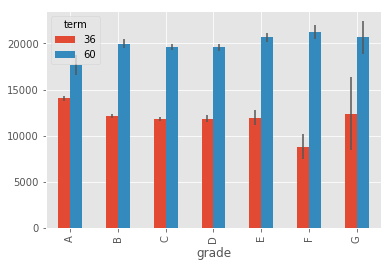

In [31]:
grouped = loans.groupby(['term','grade'])['loan_amnt']
means = grouped.mean().unstack(0)
# se = std/sqrt(N) for each group
errors = 2 * grouped.std() / np.sqrt(grouped.count())
errors = errors.unstack(0)
fig, ax = plt.subplots()
means.plot.bar(yerr=errors, ax=ax, legend='topleft')

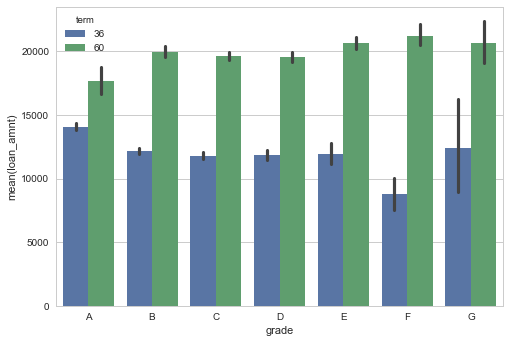

In [32]:
# An alternative solution
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x='grade', y='loan_amnt', hue='term', data=loans.sort_values('grade'))